# Transverse field lsing model to demo primitives

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

In [18]:
SYGate = UnitaryGate(YGate().power(1/2), label='$\sqrt{Y}$')
SYdgGate = UnitaryGate(YGate().inverse(), label='$\sqrt{Y}^\dag$')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Saru\AppData\Local\Temp\ipykernel_23204\2610315509.py:1: SyntaxWarning: invalid escape sequence '\s'
  SYGate = UnitaryGate(YGate().power(1/2), label='$\sqrt{Y}$')
C:\Users\Saru\AppData\Local\Temp\ipykernel_23204\2610315509.py:2: SyntaxWarning: invalid escape sequence '\s'
  SYdgGate = UnitaryGate(YGate().inverse(), label='$\sqrt{Y}^\dag$')


In [19]:
def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers=False,layer_barriers=False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    # Apply RX gates with specified angles
    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc,rx_angle,layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):
    # Adding Rzz in the even layers
    for i in range(0, qc.num_qubits - 1, 2):
        qc.sdg([i, i + 1])
        qc.append(SYGate, [i + 1])
        qc.cx(i, i + 1)
        qc.append(SYdgGate, [i + 1])
    if layer_barriers:
        qc.barrier()
    # Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits - 1, 2):
        qc.sdg([i, i + 1])
        qc.append(SYGate, [i + 1])
        qc.cx(i, i + 1)
        qc.append(SYdgGate, [i + 1])
    if layer_barriers:
        qc.barrier()
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

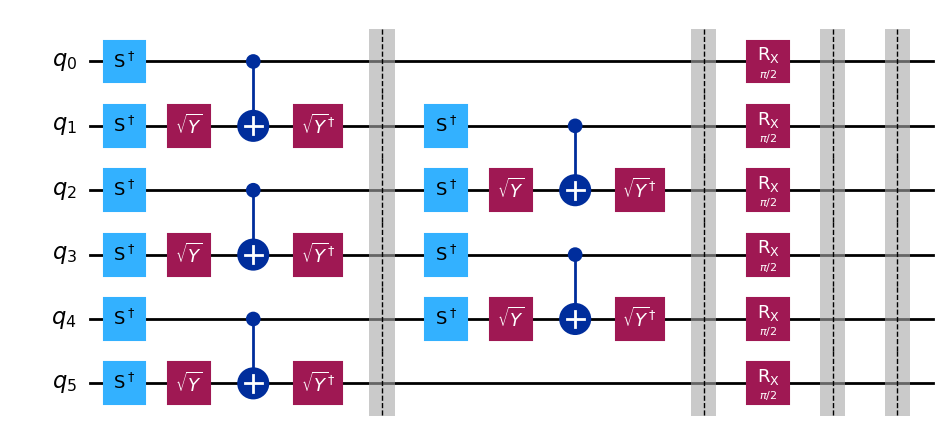

In [20]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl',fold =-1)

# Demo: Sampler

In [21]:
def append_mirrored_1d_tfim_trotter_layer(qc, num_qubits, num_trotter_step, rx_angle, trotter_barriers= False, layer_barriers=False):
    for trotter_step in range(num_trotter_step):
        add_mirrorred_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
def add_mirrorred_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    for i in range(1, qc.num_qubits - 1, 2):
        qc.append(SYGate, [i + 1])
        qc.cx(i, i + 1)
        qc.append(SYdgGate, [i + 1])
        qc.s([i, i + 1])
    if layer_barriers:
        qc.barrier()
    for i in range(0, qc.num_qubits - 1, 2):
        qc.append(SYGate, [i + 1])
        qc.cx(i, i + 1)
        qc.append(SYdgGate, [i + 1])
        qc.s([i, i + 1])
    if layer_barriers:
        qc.barrier()


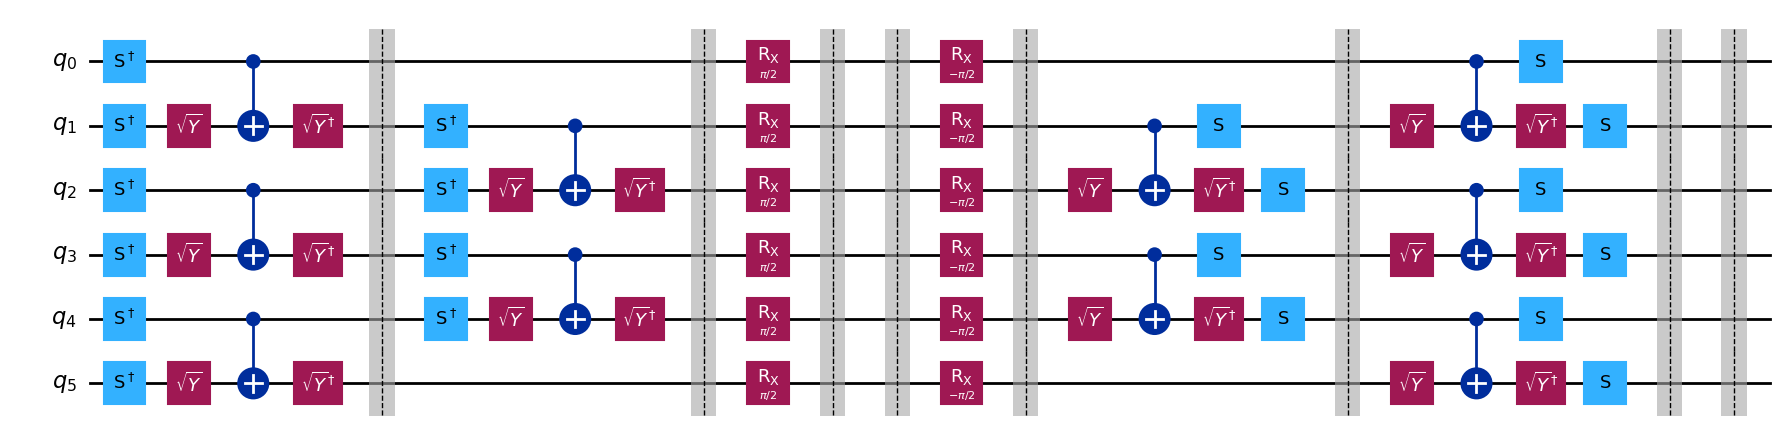

In [22]:
append_mirrored_1d_tfim_trotter_layer(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

# step 1: Map the problem to circuits and observables

In [69]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49,50]
qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, trotter_step + 1, rx_angle, num_cl_bits = len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_trotter_layer(qc, num_qubits, trotter_step + 1, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

# Step2: optimize 

In [70]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(name="ibm_brisbane")
print('Done getting the backend')

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)


C:\Users\Saru\AppData\Local\Temp\ipykernel_23204\2466676831.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


Done getting the backend


# Step 3: Execute on hardware

In [74]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

sampler = Sampler(mode=backend) 
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print("Job ID:", job.job_id())
result = job.result()
print(result)


C:\Users\Saru\AppData\Local\Temp\ipykernel_23204\1657370646.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


Job ID: d12j57mmya70008ef5vg
PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}}), Sa

# Step 4: Post-processing and plotting

In [75]:
job_id = 'd12j57mmya70008ef5vg'
job = service.job(job_id)
survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)


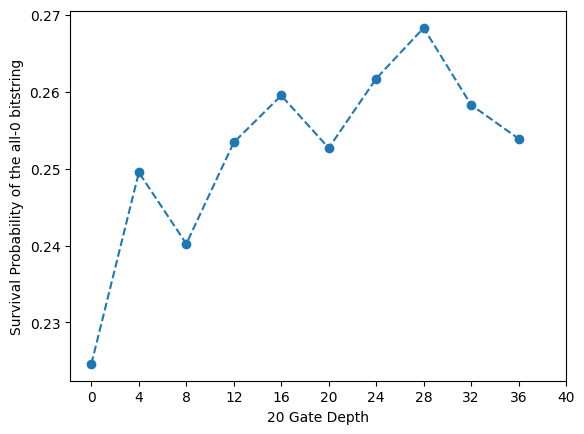

In [79]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('20 Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0,44,4))
plt.show()

# Estimation

## Step 1: Mapping the problem

In [83]:
from qiskit.circuit import Parameter
rx_angle = Parameter('rx_angle')
trotter_steps = 2
qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers=True, layer_barriers=True)

from qiskit.quantum_info import SparsePauliOp as SPO

middle_index = num_qubits // 2
observable = SPO('I' * middle_index + 'Z' + 'I'*(middle_index - 1))


## Step 2: Optimize the circuit

In [86]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(qc_transpiled.layout)   


C:\Users\Saru\AppData\Local\Temp\ipykernel_23204\2087029189.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


## Step 3: Execute on quantum hardware

In [90]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi / 2
num_points = 12
trotter_steps = 2
rx_angles_list = np.linspace(min_rx_angle, max_rx_angle, num_points)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(mode=backend, options=options)
job = estimator.run([(qc_transpiled, observable, rx_angles_list)])
print("Job ID:", job.job_id())

Job ID: d12jgvkqf56g0081mk6g


d:\miniconda3\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


## Step 4: Post-processing and plotting

(-0.1, 0.1)

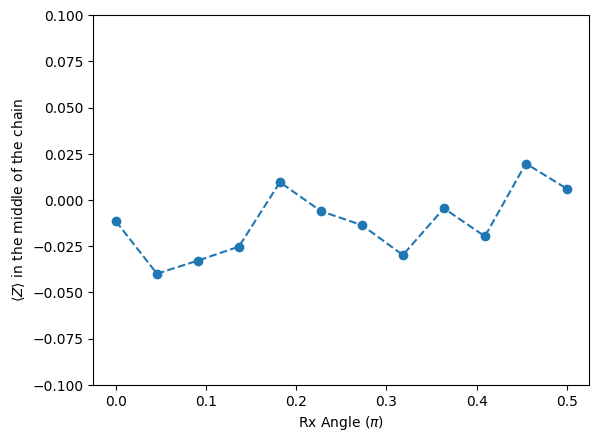

In [92]:
job_id = 'd12jgvkqf56g0081mk6g'
job = service.job(job_id)

exp_val_list = job.result()[0].data.evs

plt.plot(rx_angles_list / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx Angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle$ in the middle of the chain')
plt.ylim(-0.1, 0.1)

